# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, split_dataset, preprocess_dataset

columns_to_drop = ['filename', 'label']

def preprocess(df):
    # YOUR CODE HERE
    
    # Split the dataset into training (70%) and testing (30%) sets
    # Accompanied with encoding the labels from 0 to n_classes-1 
    X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size, random_state)
    
    # Scale and prepare testing data
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

test_size = 0.3 
random_state = 42

X_train, y_train, X_test, y_test = preprocess(df)

In [3]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8439, 77) (8439,)
(3618, 77) (3618,)


3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [10]:
from torch import optim
from common_utils import EarlyStopper

epoch_time_dict = {}
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size, num_neurons):

    # YOUR CODE HERE
    
    epochs = 100
    
    # Convert input data to PyTorch tensors
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val2)

    # Create DataLoader for training data
    train_dataset = CustomDataset(X_train_scaled, y_train2)
    test_dataset = CustomDataset(X_val_scaled, y_val2)
    
    # Creating Dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create and initialize the model
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize EarlyStopper
    early_stopper = EarlyStopper(patience=3, min_delta=0)
    
    # Lists to store training information for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    times = []
    epoch_time = []
    
    # Record Time Taken for when Training Starts
    start_time = time.time()
    
    for epoch in range(epochs):
        
        # Record Time Taken for when Epochs Start
        epoch_start = time.time()
        
        model.train()
        total_loss = 0
        correct_train = 0

        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = total_loss / len(train_dataloader)
        train_accuracy = correct_train / len(train_dataloader.dataset)

        # Validation loop
        model.eval()
        total_loss = 0
        correct_test = 0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_test += (predicted == labels).sum().item()

            average_validation_loss = total_loss / len(test_dataloader)
            test_accuracy = correct_test / len(test_dataloader.dataset)
        
        # Early stopping check based on validation loss
        if early_stopper.early_stop(average_validation_loss):
            epoch_end = time.time() - epoch_start
            epoch_time.append(epoch_end)
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            print(f"Time Taken for Epoch: {epoch_end}")
            break

        # Append information for plotting
        train_losses.append(average_train_loss)
        test_losses.append(average_validation_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        times.append(time.time() - start_time)
        epoch_time_dict[num_neurons] = epoch_time
    

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [11]:
epoch_acc_dict = {}

def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE
    optimal_hyperparameters = {}
    cross_validation_accuracies = []
    cross_validation_times = []

    for num_neurons in parameters:
        # Initialize a list to store cross-validation accuracies for this number of neurons
        fold_accuracies = []
        fold_times = []

        # Perform k-fold cross-validation (e.g., k=5)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Initialise Fold Counter
        fold = 1
        
        for train_idx, val_idx in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Create and train the neural network model
            model = MLP(no_features=X_train.shape[1], no_hidden=num_neurons, no_labels=2)
            train_accuracies, _, test_accuracies, _, times = train(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size, num_neurons)
            
            epoch_acc_dict[num_neurons] = test_accuracies

            #print(times)
            # Evaluate the model on the validation fold
            fold_accuracy = np.mean(test_accuracies)
            fold_time = np.mean(times)
 
            # Appending to the list
            fold_accuracies.append(fold_accuracy)
            fold_times.append(fold_time)
            
            print(f"Number of Hidden Neurons: {num_neurons} | Fold {fold} | Training Accuracy: {fold_accuracy}")
            
            fold += 1

        # Calculate the mean accuracy and time across all folds
        mean_accuracy = np.mean(fold_accuracies)
        mean_time = np.mean(fold_times)
        
        cross_validation_accuracies.append(mean_accuracy)
        cross_validation_times.append(mean_time)
        
        if mode not in optimal_hyperparameters:
            optimal_hyperparameters[mode] = []
        optimal_hyperparameters[mode].append(num_neurons)
        
        print(f"Mean Training Time: {mean_time} seconds")
        print(f"Mean 5-Fold Cross Validation Accuracy: {mean_accuracy}")
        print("----------------------------------------------------------------------------------")

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
optimal_bs = 512
num_neurons = [64,128,256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train, y_train, num_neurons, 'num_neurons', optimal_bs)


Early stopping triggered at epoch 38.
Time Taken for Epoch: 0.09101700782775879
Number of Hidden Neurons: 64 | Fold 1 | Training Accuracy: 0.6492890995260664
Early stopping triggered at epoch 36.
Time Taken for Epoch: 0.09312272071838379
Number of Hidden Neurons: 64 | Fold 2 | Training Accuracy: 0.6342078537576166
Early stopping triggered at epoch 41.
Time Taken for Epoch: 0.09272003173828125
Number of Hidden Neurons: 64 | Fold 3 | Training Accuracy: 0.6476303317535546
Early stopping triggered at epoch 60.
Time Taken for Epoch: 0.09181785583496094
Number of Hidden Neurons: 64 | Fold 4 | Training Accuracy: 0.6550224917664069
Early stopping triggered at epoch 40.
Time Taken for Epoch: 0.11517620086669922
Number of Hidden Neurons: 64 | Fold 5 | Training Accuracy: 0.6367394707643672
Mean Training Time: 2.207388776376724 seconds
Mean 5-Fold Cross Validation Accuracy: 0.6445778495136023
----------------------------------------------------------------------------------
Early stopping triggere

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

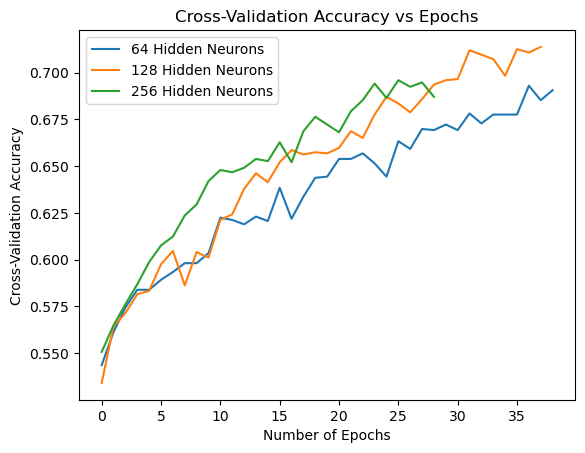

In [12]:
# YOUR CODE HERE

# Plot to visualise the mean cross-validation accuracy for different number of hidden neurons
# Hidden Neurons = 64
y1 = epoch_acc_dict[64]
plt.plot(y1, label = "64 Hidden Neurons")

# Hidden Neurons = 16
y2 = epoch_acc_dict[128]
plt.plot(y2, label = "128 Hidden Neurons")

# Hidden Neurons = 32
y3 = epoch_acc_dict[256]
plt.plot(y3, label = "256 Hidden Neurons")


plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs Epochs')
plt.legend()
plt.show()

In [14]:
epoch_time_list = list()
for i in epoch_time_dict.values():
    epoch_time_list.append(i[0])

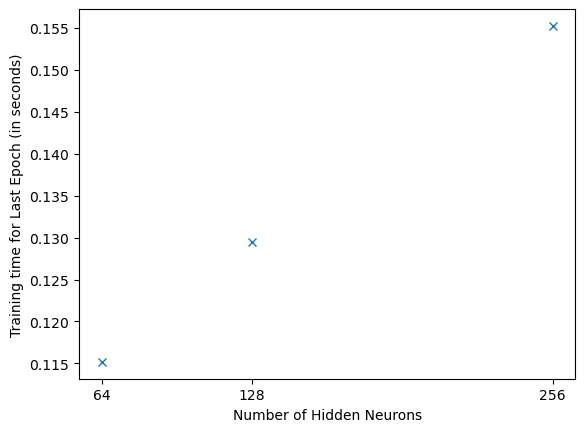

In [16]:
plt.plot(num_neurons, epoch_time_list, marker = 'x', linestyle = 'None')
plt.xticks(num_neurons)
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Training time for Last Epoch (in seconds)')
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [19]:
optimal_neurons = 128
reason = """ 
        As we can tell from the graphs above, the cross-validation accuracy is the highest when the hidden layer of
        neurons is 128 and the training time for the last epoch is comparable to the fastest training time. Hence,
        the most optimal neurons should be 128.
"""
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

Early stopping triggered at epoch 31.
Time Taken for Epoch: 0.18349695205688477


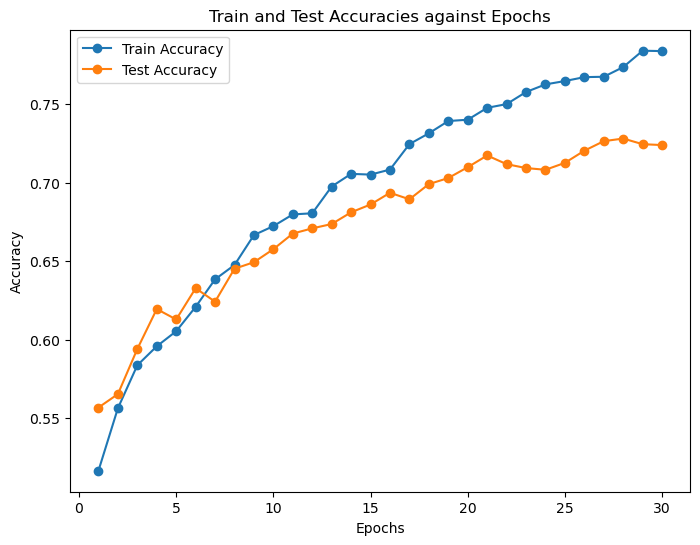

In [28]:
# YOUR CODE HERE

# Initialising model based on the optimal number of neurons
model = MLP(no_features=X_train.shape[1], no_hidden=optimal_neurons, no_labels=2)
train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train, y_train, X_test,
                                                                            y_test, optimal_bs, optimal_neurons)
# Saving Optimal Model State for A4
torch.save(model.state_dict(), 'pretrained_MLP.pth')

plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies against Epochs')
plt.legend()
plt.show()